In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))  # 把工作路径转到主目录下

In [2]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.preprocess import load_testcnn_data, load_tokenizer_binarizer
tf.__version__

'2.0.0'

# **Transformer简介**
文本分类模型是根据[tensorflow的教程](https://tensorflow.google.cn/tutorials/text/transformer)修改而来的，如果想学习transformer可以直接跑它的案例，不需要看这篇。这篇主要是把机器翻译模型改造成了文本分类模型。

之后要运用bert，而transformer是bert的前置基础，所以还是实现一下transformer

Transformer 模型的核心思想是**自注意力机制（self-attention）**——能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的**按比缩放的点积注意力（Scaled dot product attention）**和**多头注意力（Multi-head attention）**部分对此进行了说明。

一个 transformer 模型用自注意力层而非 [RNNs](https://tensorflow.google.cn/tutorials/text/text_classification_rnn) 或 [CNNs](https://tensorflow.google.cn/tutorials/images/intro_to_cnns) 来处理变长的输入。这种通用架构有一系列的优势：

- 它不对数据间的时间/空间关系做任何假设。
- 层输出可以**并行计算**，而非像 RNN 这样的序列计算。
- **远距离项可以影响彼此的输出**，而无需经过许多 RNN 步骤或卷积层（例如，参见[场景记忆 Transformer（Scene Memory Transformer）](https://arxiv.org/pdf/1903.03878.pdf)）
- 它能**学习长距离的依赖**。在许多序列任务中，这是一项挑战。

该架构的缺点是：

- 对于时间序列，一个单位时间的输出是从**整个历史记录**计算的，而非仅从输入和当前的隐含状态计算得到。这可能效率较低。   
- 如果输入**确实**有时间/空间的关系，像文本，则必须加入一些位置编码，否则模型将有效地看到一堆单词。（这个翻译有毒，应该说的是翻译的句子语序会乱七八糟）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

## **Postion Encoding**


$$\begin{aligned}
P E_{(p o s, 2 i)} &=\sin \left(\operatorname{pos} / 10000^{2 i / d_{\text {model}}}\right) \\ P E_{(p o s, 2 i+1)} &=\cos \left(\text {pos} / 10000^{2 i / d_{\text {model}}}\right)
\end{aligned}$$

$pos$是词在句子中的位置，$d_{model}$是嵌入层的维度，$i$是嵌入层的某一维。

In [3]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [4]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

这个图我的理解是x轴画的维度太多了，以致于看起来效果不好。

In [5]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


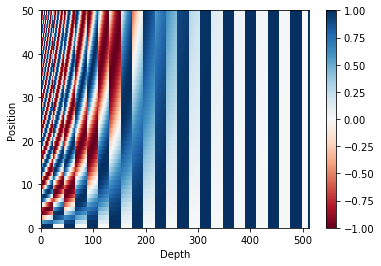

In [6]:
plt.figure()
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

这样画浅一点就比较好看到每个词位置编码的变化情况

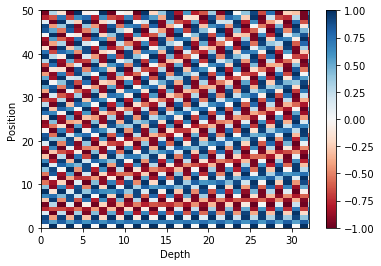

In [7]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 32))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## **Masking**

为了模型不会将padding作为输入。**mask值等于1表示这个词是padding词**

### padding mask

In [8]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [9]:
# 预留的两个维度是用来广播的
# 留给head和seq_len_q
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=17, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### look ahead mask

为了不提前泄露信息，比如预测第三个词的时候，模型只能看到第一第二个词。

专门在自注意力的时候用，问题：
- encoder的mask是look ahead还是padding  (padding)  
- decoder的第一个mha的mask的look ahead还是padding  (look ahead)

注意这是比较关键的一点，**尽管Encoder和Decoder都有自注意力这一环节，但是encoder是没有look head mask的**

In [10]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [11]:
# 有1表示词被mask掉了
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=32, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## **Scaled dot product attention**

![](https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png)

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样**会获得一个更平缓的 softmax**。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

### 深度搞懂点积注意力
- 讲道理1个公式和8行代码**背下来不过分吧？**（好像有点过分，那把图背下来应该不过分）
- 输入是什么，输入的维度是怎样的？
- 计算出来的attention维度是怎样的？
- q k v 的含义和作用？
- 为什么要缩小$\sqrt{d_k}$倍？
- mask怎么用？

- query向量：query顾名思义，是负责寻找**这个字的于其他字的相关度**（通过其它字的key） 
- key向量：key向量就是用来于query向量作匹配，得到相关度评分的 
- value向量：Value vectors 是实际上的**字的表示**(词向量?), 一旦我们得到了字的相关度评分，这些表示是用来加权求和的

得到每个字的  之后，我们要得到每个字和句子中其他字的相关关系，我们只需要把这个字的query去和其他字的key作匹配，然后得到分数，最后在通过其它字的value的加权求和（权重就是哪个分数）得到这个字的最终输出。

In [12]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。比如(batch_size, num_heads)
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    好像大部分情况，q k v的最后一维也是相同的
    参数:
      q: 请求的形状 == (..., seq_len_q, depth)
         q to match others 是负责寻找这个字的于其他字的相关度（通过其它字的key）
      k: 主键的形状 == (..., seq_len_k, depth)
         k to be matched key向量就是用来于query向量作匹配，得到相关度评分的
      v: 数值的形状 == (..., seq_len_v, depth_v)
         v information to be extracted
         v就是原输入经过一层全连接编码后新的词向量
         是实际上的字的表示, 一旦我们得到了字的相关度评分，这些表示是用来加权求和的
      mask: Float 张量，其形状能转换成
            (..., seq_len_q, seq_len_k)。默认为None。

    实际的形状可能就是：
    (batch_size, head_nums, seq_len_q, depth)
    (128,        8,         50,        512)
    
    返回值:
      输出 shape == (..., seq_len_q, depth_v)
      注意力权重 shape == (..., seq_len_q, seq_len_v)
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # (..., seq_len_q, seq_len_k)

    # 将 mask 加入到缩放的张量上。
    # 加上一个很大的负数，使softmax对应单元变成0
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 为什么要缩放根号dk倍

In [13]:
q = tf.random.normal((3, 256))  # 一句有3个单词，词向量为256维的话
k = tf.random.normal((4, 256))  # 告诉q该怎么关注v
v = tf.random.normal((4, 256))  # 一句有4个单词，词向量为256维的话

# 查看q,k的均值和方差
print('query mean: {:.4f} std : {:.4f}'.format(q.numpy().mean(), q.numpy().std()))
print('key mean: {:.4f} std : {:.4f}'.format(k.numpy().mean(), k.numpy().std()))

query mean: -0.0048 std : 1.0189
key mean: 0.0308 std : 1.0356


In [14]:
dk = tf.cast(tf.shape(k)[-1], tf.float32)
matmul_qk = tf.matmul(q, k, transpose_b=True)
print('dk : %d'% dk.numpy())
print('qk mean: {:.4f} std : {:.4f}'.format(matmul_qk.numpy().mean(), matmul_qk.numpy().std()))

dk : 256
qk mean: 3.7964 std : 14.1632


这里的$d_k$是256维度的，所以$\sqrt{d_k}=16$。而且当$QK^T$过后计算得到的句子的**标准差被放大了**。（要是能从数学角度分析就好了。）

下面分别展示不缩放和缩放的softmax结果

可以看到如果不缩放。最终算出来的注意力是一个很**hard**的 softmax。某些行的取值非常接近1。而缩放了过后，就相对比较软。

In [15]:
# 未缩放softmax
tf.nn.softmax(matmul_qk, axis=-1)

<tf.Tensor: id=58, shape=(3, 4), dtype=float32, numpy=
array([[1.0000000e+00, 7.6465666e-21, 1.6317354e-13, 1.2165578e-12],
       [6.7943824e-07, 9.9948716e-01, 3.6093361e-11, 5.1205611e-04],
       [2.2132143e-03, 9.9761343e-01, 1.7344809e-04, 3.8847052e-14]],
      dtype=float32)>

In [16]:
# 缩放softmax
c = matmul_qk / tf.math.sqrt(dk)
attention_weights = tf.nn.softmax(c, axis=-1)
attention_weights

<tf.Tensor: id=61, shape=(3, 4), dtype=float32, numpy=
array([[0.71731013, 0.03966647, 0.11389314, 0.12913018],
       [0.18238981, 0.44307506, 0.09858945, 0.27594566],
       [0.28323096, 0.41496542, 0.2415599 , 0.0602437 ]], dtype=float32)>

**点积注意力的输出**

顺便把结果也计算出来吧。最后得到了一个和$Q$等大矩阵。这个矩阵的含义是什么呢？

每一行是一个词，这个词的词向量是$V$矩阵加权求和的结果。也就是说对于$Q$中的每个词都计算一下它和$V$中的词的关联度。

比如:
- 中文：她 真 漂亮
- 英文：she is very beautiful

经过点积注意力的计算后，最后的结果可能是 

$$
\begin{aligned}
q(她) &= 0.5 \times v(she) + 0.15 \times v(is) + 0.05 \times v(very) +  0.3 \times v(beautiful)\\
q(真) &= 0.2 \times v(she) + 0.1 \times v(is) + 0.6 \times v(very) +  0.1 \times v(beautiful)\\
q(漂亮) &= 0.2 \times v(she) + 0.05 \times v(is) + 0.25 \times v(very) +  0.5 \times v(beautiful)
\end{aligned}
$$

In [17]:
output = tf.matmul(attention_weights, v)
output.shape

TensorShape([3, 256])

### mask=1的意义
[softmax的实现及数值稳定性](https://blog.csdn.net/weixin_34353714/article/details/89039235)

In [18]:
def softmax(x):
    """Compute the softmax in a numerically stable way.""" # 防止如果x中的值太大，会溢出
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [19]:
x = np.array([1, 2, 3])
mask = np.array([0, 0, 1])
softmax(x)  # 不加mask

array([0.09003057, 0.24472847, 0.66524096])

In [20]:
mask_x = x + mask * -1e9
softmax(mask_x)  # 加了mask后对应位置会变成0

array([0.26894142, 0.73105858, 0.        ])

### 演示

In [21]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [22]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


怎么理解这个演示呢？我的理解是这里输入的q是一个只是一个词，计算得到的注意力是`[0, 1, 0, 0]`表示它应该关注v的第二个词。

v是一句话4个单词的**词向量**，k是指导q该怎么关注v的**引路人**。

而**output**就是关注的结果。

In [23]:
# 这条请求符合重复出现的主键（第三第四个），
# 因此，对所有的相关数值取了平均。
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [24]:
# 这条请求符合第一和第二条主键，
# 因此，对它们的数值去了平均。
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [25]:
# 将所有请求一起传递
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## **Multi-head attention**

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

### 深度搞懂多头注意力
- 图背下来
- Q,K,V是怎么来的？
- 为什么多头可以关注不同位置的信息？
- 输入输出是什么维度是怎样的？

In [26]:
# Multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # 我暂时把这个理解为词向量维度

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # 拆分多头后的维度

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        
        原本 (batch_size, seq_len, d_model) 实际上就是把d_model分成了8份
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # 这是需要学习的参数
        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  
        # 要学习的参数
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  

        return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

`y`就是一个有60个单词的句子。第一个维度1表示的是batch_size，只不过这里就用一个样本来举例。这里输入和输出的维度是一样的。在后面的**Encoder**可以了解到，**Encoder**的qkv全是一样的。这应该就是体现出了所谓的**自注意力机制**？而在**Decoder**中，kv是**Encoder**的输出。

在**Decoder**中的x经过三个全连接层变成了qkv，然后qkv在执行分头操作。以下这张图是q或k，v其中一个分头执行的操作

![](../images/transforme分头.png)

In [27]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### 分头函数reshape位置不同的区别

In [28]:
x = np.array([[i*10+j for j in range(8)] for i in range(5)])
x

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [20, 21, 22, 23, 24, 25, 26, 27],
       [30, 31, 32, 33, 34, 35, 36, 37],
       [40, 41, 42, 43, 44, 45, 46, 47]])

In [29]:
# 原始x shape (5, 8)  # 表示5个单词8维词向量
# 4 是表示4个头，2 是表示分完后的深度
# 目的是把一句话的词向量分词4段 
# 之后还要执行.transpose(1,0,2) 目的是分成4个头好计算
# 为什么是-1而不是直接填seq_len呢，这是因为encoder和decoder的句子长度**可能**是不一样的。
# 而头数和词向量长度是固定的
np.reshape(x, (-1, 4, 2))  

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7]],

       [[10, 11],
        [12, 13],
        [14, 15],
        [16, 17]],

       [[20, 21],
        [22, 23],
        [24, 25],
        [26, 27]],

       [[30, 31],
        [32, 33],
        [34, 35],
        [36, 37]],

       [[40, 41],
        [42, 43],
        [44, 45],
        [46, 47]]])

In [30]:
# 如果按照这样分，会有错吗？
# 明显有错，这一个向量都分到了第二个句子去了
np.reshape(x, (4, -1, 2))

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [10, 11]],

       [[12, 13],
        [14, 15],
        [16, 17],
        [20, 21],
        [22, 23]],

       [[24, 25],
        [26, 27],
        [30, 31],
        [32, 33],
        [34, 35]],

       [[36, 37],
        [40, 41],
        [42, 43],
        [44, 45],
        [46, 47]]])

## **Point wise feed forward network**
点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

这个网络不会改变向量的大小，只是做了一步提取特征的工作

In [31]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [32]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## **Encoder and Decoder**

![](../images/transformer.png)

Transformer 模型与标准的[具有注意力机制的序列到序列模型（sequence to sequence with attention model）](https://tensorflow.google.cn/tutorials/text/nmt_with_attention)，遵循相同的一般模式。

- 输入语句经过 `N` 个编码器层，为序列中的每个词/标记生成一个输出。
- 解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

编码器层（Encoder layer）

每个编码器层包括以下子层：

1. 多头注意力（有padding mask）
2. 点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个**残差连接**，然后进行层归一化。残差连接**有助于避免深度网络中的梯度消失问题**。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。(**使激活值均值为0方差为1**)



### Encoder Layer

每个编码器层包括以下子层：

1. 多头注意力（有填充遮挡）
2. 点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [33]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # epsilon 避免除0
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # training 表示是否在训练模式下执行dropout 多头注意力的第二个输出：注意力权重是被忽略的
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        # out2 作为decoder的v和k
        return out2

In [34]:
# 512维 8个头 前馈神经网络隐藏层2048维
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), training=False, mask=None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer 

每个解码器层包括以下子层：

1.   mask的多头注意力（padding mask 和 look ahead mask）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收**Encoder输出**作为输入。Q（请求）接收**mask的多头注意力子层的输出**。
3.   点式前馈网络
- 2个多头注意力层
- 3个layer normalize

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

**输出**
- 提取特征后的与x等大的tensor
- 两个mha的注意力

![](../images/transformer.png)

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # 第一个mha需要look_ahead_mask 第二个mha需要padding_mask
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [36]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [37]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        # (batch_size, max_seq_len, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)

        # 为什么要乘以embedding size的开方？
        # 猜测是因为embedding matrix的初始化方式是xavier init，这种方式的方差是1/embedding size，
        # 因此乘以embedding size的开方使得embedding matrix的方差是1，在这个scale下可能更有利于embedding matrix的收敛。
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        # 这里对embedding来了个dropout
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        # 输出的这个x作为Decoder的q和v
        return x  # (batch_size, input_seq_len, d_model)

这里我有个困惑的点是为什么`maximum_position_encoding`的值要设置那么大？

In [38]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

# 输入：(batch_size, seq_len)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

# 输出：(batch_size, seq_len, embedding_dim)  可以理解为词向量
print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [39]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # embedding
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 理由同编码器
        
        # 位置编码
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # v, k, q
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [40]:
# 简单搞个2层的， dmodel就是词向量的维度
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## **创建Transformer**

In [41]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        # diff 是点式前馈网络的隐藏层神经元个数
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [42]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))  # 一句话62个词
temp_target = tf.random.uniform((64, 26))  # 一句话26个词

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## **创建分类用的Transformer**

上面那个transformer是翻译任务用的。对于分类任务不需要decoder。直接将encoder的输出接一个全连接层来分类即可。

这里可以参考TextCNN最后的输出来改

In [43]:
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 vocab_size, position, output_dim, rate=0.1):
        
        # diff 是点式前馈网络的隐藏层神经元个数
        super(TransformerClassifier, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               vocab_size, position, rate)

        self.dense = tf.keras.layers.Dense(output_dim)
        
        #self.x_flatten = tf.keras.layers.Flatten()  # flatten()是拉直我这里没有选择这个，而是求平均
        

    def call(self, x, training, enc_padding_mask):
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(x, training, enc_padding_mask)
        
        # (batch_size, d_model*seq_len)
        # enc_output = self.x_flatten(enc_output)
        
        # (batch_size, d_model)
        enc_output = tf.reduce_mean(enc_output, axis=1)
        
        # (batch_size, output_dim)  # 之前少了求均值这一步
        y = self.dense(enc_output)

        return y

In [44]:
# (batch_size, seq_len)  (batch_size, label_nums)
temp_x = tf.random.uniform((128, 128))
temp_y = tf.random.uniform((128, 97))
print(temp_x.shape, temp_y.shape)

(128, 128) (128, 97)


In [45]:
sample_transformer = TransformerClassifier(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    vocab_size=50000, position=10000,output_dim=temp_y.shape[1])

temp_y_pred = sample_transformer(temp_x, training=False,enc_padding_mask=None)

# **训练**

## **Dataset**

In [46]:
# testcnn和transformer预处理的数据是一致的
train_x, dev_x, test_x, train_y, dev_y, test_y = load_testcnn_data()
tokenizer, mlb = load_tokenizer_binarizer()
BUFFER_SIZE = 256
BATCH_SIZE = 128

In [47]:
# train_x = train_x.astype(np.float32)
# train_y = train_y.astype(np.float32)

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_x, dev_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# 将数据集缓存到内存中以加快读取速度。
dev_dataset = dev_dataset.cache()
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=True)

dev_dataset = dev_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## **hyperparameters**

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。 

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [49]:
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
vocab_size = 50000
maximum_position_encoding=10000
output_dim = len(train_y[0])  # 97
dropout_rate = 0.1
# max_seq_len = 128

steps_per_epoch = len(train_x) // BATCH_SIZE
epochs = 5

## **建立模型**

In [50]:
model = TransformerClassifier(num_layers, d_model, num_heads, dff, vocab_size, 
                                    maximum_position_encoding, output_dim, dropout_rate)

## **Optimizer**
根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [52]:
learning_rate = CustomSchedule(d_model)

# 配置优化器
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

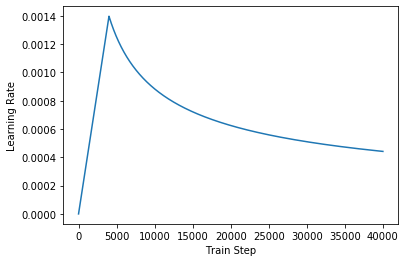

In [53]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## **Loss and metrics**
由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

```python
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
```
上面这个是是机器翻译的损失函数。

In [54]:
# 多标签分类损失函数
# 如果设置reduction='none'就表示不会帮你自动求平均
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='auto')

In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
# 凑 之前忘记把SparseCategoricalAccuracy 改成 BinaryAccuracy 了
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

**自定义指标**

In [56]:
from utils.metrics import micro_f1, macro_f1

## **checkpointing**

In [57]:
checkpoint_path = "notebook/Transformer/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## **Training**

### 普通写法
从TextCNN拷贝过来然后稍作调整

In [58]:
for epoch in range(epochs):
    start = time.time()
    total_loss = 0
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        enc_padding_mask = create_padding_mask(x)
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
            loss = loss_object(y, y_pred)
        total_loss += loss
        
        variables = model.trainable_variables
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        if batch % 20 == 0:
            print('epoch {} batch {:3d} loss {:.4f}'.format(epoch+1, batch+1, loss.numpy()))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                       total_loss / steps_per_epoch))
    
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


epoch 1 batch   1 loss 0.9952
epoch 1 batch  21 loss 0.6218
epoch 1 batch  41 loss 0.1996
epoch 1 batch  61 loss 0.1622
epoch 1 batch  81 loss 0.1458
epoch 1 batch 101 loss 0.1569
epoch 1 batch 121 loss 0.1427
epoch 1 batch 141 loss 0.1523
Epoch 1 Loss 0.2817
Time taken for 1 epoch 63.22 sec

epoch 2 batch   1 loss 0.1367
epoch 2 batch  21 loss 0.1387
epoch 2 batch  41 loss 0.1326
epoch 2 batch  61 loss 0.1168
epoch 2 batch  81 loss 0.0987
epoch 2 batch 101 loss 0.0957
epoch 2 batch 121 loss 0.0779
epoch 2 batch 141 loss 0.0701
Epoch 2 Loss 0.1050
Time taken for 1 epoch 61.64 sec

epoch 3 batch   1 loss 0.0661
epoch 3 batch  21 loss 0.0593
epoch 3 batch  41 loss 0.0694
epoch 3 batch  61 loss 0.0604
epoch 3 batch  81 loss 0.0527
epoch 3 batch 101 loss 0.0423
epoch 3 batch 121 loss 0.0416
epoch 3 batch 141 loss 0.0360
Epoch 3 Loss 0.0521
Time taken for 1 epoch 61.18 sec

epoch 4 batch   1 loss 0.0399
epoch 4 batch  21 loss 0.0511
epoch 4 batch  41 loss 0.0323
epoch 4 batch  61 loss 0.044

### 也许是更好的写法

- 加入`tf.function`可以看到下面的训练时间确实缩短了
- 添加检查点保存功能


#### **评估函数**

想实现每个epoch结束后评估一下验证集的指标

In [59]:
def predict(x, batch_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)
    res = []
    for batch_x in dataset:
        enc_padding_mask = create_padding_mask(batch_x)
        
        y_pred = model(batch_x, training=False, enc_padding_mask=enc_padding_mask)
        res.append(y_pred)
        
    res = tf.concat(res, axis=0)
    return res

In [60]:
def evaluation(x, y):
    y = tf.cast(y, dtype=tf.float32)
    y_pred = predict(x)
    
    predict_accuracy = tf.keras.metrics.BinaryAccuracy(name='predict_accuracy')
    acc = predict_accuracy(y, y_pred)
    mi_f1=micro_f1(y, y_pred)
    ma_f1=macro_f1(y, y_pred)
    
    print("val accuracy {:.4f}, micro f1 {:.4f} macro f1 {:.4f}".format(
                    acc.numpy(), mi_f1.numpy(), ma_f1.numpy()))
    return acc, mi_f1, ma_f1

ps:之前这个函数老是报错，之后发现是`train_dataset`的数据格式要改成`tf.float32`的而且需要标明x的第二个维度。这个原因我目前还没太懂，可能是tensorflow的某种机制？

In [84]:
# 重置模型和优化器
model = TransformerClassifier(num_layers, d_model, num_heads, dff, vocab_size, 
                                    maximum_position_encoding, output_dim, dropout_rate)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

# 我发现不重置检查点的话模型还是原来的
checkpoint_path = "notebook/Transformer/checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [86]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。
# 这里填的128指的是句子的长度
train_step_signature = [
    tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(x, y):
  
    enc_padding_mask = create_padding_mask(x)
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
        loss = loss_object(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
    train_loss(loss)
    train_accuracy(y, y_pred)
    
    mi_f1=micro_f1(y, y_pred)
    ma_f1=macro_f1(y, y_pred)
    return mi_f1, ma_f1, y_pred


# 训练
for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        mi_f1 ,ma_f1, _ = train_step(x, y)
        
        if batch % 20 == 0:
            print('epoch {} batch {:3d} loss {:.4f} acc {:.4f} micro_f1 {:.4f} macro_f1 {:.4f}'.format(
                epoch+1, batch+1, train_loss.result(), 
                train_accuracy.result(), mi_f1, ma_f1))

    # 每隔5轮保存一下        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    evaluation(dev_x, dev_y)
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

epoch 1 batch   1 loss 0.8213 acc 0.6620 micro_f1 0.0550 macro_f1 0.0494
epoch 1 batch  21 loss 0.7047 acc 0.7336 micro_f1 0.0509 macro_f1 0.0237
epoch 1 batch  41 loss 0.5115 acc 0.8287 micro_f1 0.0296 macro_f1 0.0030
epoch 1 batch  61 loss 0.3994 acc 0.8705 micro_f1 0.0279 macro_f1 0.0020
epoch 1 batch  81 loss 0.3391 acc 0.8920 micro_f1 0.1041 macro_f1 0.0075
epoch 1 batch 101 loss 0.3020 acc 0.9051 micro_f1 0.1242 macro_f1 0.0098
epoch 1 batch 121 loss 0.2765 acc 0.9139 micro_f1 0.1513 macro_f1 0.0131
epoch 1 batch 141 loss 0.2578 acc 0.9203 micro_f1 0.1564 macro_f1 0.0151
Epoch 1 Loss 0.2516
val accuracy 0.9599, micro f1 0.1886 macro f1 0.0157
Time taken for 1 epoch 45.01 sec

epoch 2 batch   1 loss 0.1451 acc 0.9571 micro_f1 0.1887 macro_f1 0.0200
epoch 2 batch  21 loss 0.1336 acc 0.9614 micro_f1 0.2915 macro_f1 0.0452
epoch 2 batch  41 loss 0.1267 acc 0.9631 micro_f1 0.3901 macro_f1 0.0646
epoch 2 batch  61 loss 0.1205 acc 0.9643 micro_f1 0.4636 macro_f1 0.1017
epoch 2 batch  81

# 预测

In [63]:
res = predict(test_x)

In [64]:
macro_f1(tf.cast(test_y, dtype=tf.float32), res)

<tf.Tensor: id=1599225, shape=(), dtype=float32, numpy=0.81561065>

In [66]:
res = np.where(res.numpy()>0.5, 1, 0)

In [68]:
mlb.inverse_transform(res)

[('公民道德与伦理常识', '政治', '社会主义市场经济的伦理要求'),
 ('地理', '太阳对地球的影响', '宇宙中的地球'),
 ('人口与城市', '人口增长与人口问题', '地理'),
 ('人工授精、试管婴儿等生殖技术', '减数分裂与有丝分裂的比较', '生物', '生物性污染', '生物科学与社会', '避孕的原理和方法'),
 ('历史', '垄断组织的出现', '清末民主革命风潮', '近代史'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球运动的地理意义', '地理', '宇宙中的地球'),
 ('生物', '生物技术在其他方面的应用', '生物技术实践'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球运动的基本形式', '地理', '宇宙中的地球'),
 ('历史', '文艺的春天', '现代史'),
 ('历史', '近代史'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的分离规律的实质及应用',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法'),
 ('生物', '生物科学与社会'),
 ('生物', '生物工程技术', '生物技术在其他方面的应用', '生物技术实践'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的自由组合规律的实质及应用',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法'),
 ('培养基与无菌技术', '生物', '生物技术在其他方面的应用', '生物技术实践'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球运动的地理意义', '地理', '

In [69]:
mlb.inverse_transform(test_y)

[('公民道德与伦理常识', '政治', '社会主义市场经济的伦理要求'),
 ('地理', '太阳对地球的影响', '宇宙中的地球'),
 ('人口与城市', '人口增长与人口问题', '地理'),
 ('人工授精、试管婴儿等生殖技术', '减数分裂与有丝分裂的比较', '生物', '生物性污染', '生物科学与社会', '避孕的原理和方法'),
 ('历史', '清末民主革命风潮', '近代史'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球运动的地理意义', '地理', '宇宙中的地球'),
 ('生物', '生物工程技术', '生物技术实践'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球运动的基本形式', '地理', '宇宙中的地球'),
 ('历史', '古代史', '文艺的春天'),
 ('历史', '近代史'),
 ('人工授精、试管婴儿等生殖技术',
  '伴性遗传',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法'),
 ('生物', '稳态与环境'),
 ('生物', '生物工程技术', '生物技术实践'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的自由组合规律的实质及应用',
  '生物',
  '生物性污染',
  '生物科学与社会',
  '遗传的分子基础',
  '遗传的细胞基础',
  '避孕的原理和方法'),
 ('培养基与无菌技术', '生物', '生物技术在其他方面的应用', '生物技术实践'),
 ('人体免疫系统在维持稳态中的作用',
  '体液免疫的概念和过程',
  '免疫系统的功能',
  '免疫系统的组成',
  '内环境的稳态',
  '生物',
  '稳态与环境'),
 ('地球与地图', '地理'),
 ('人工授精、试管婴儿等生殖技术',
  '基因的自由组合规律的实质及应用',
  '生物',

更详细的绘图和分析请看`Transformer运用.ipynb`